In [ ]:
from google.colab import drive
drive.mount("/gdrive", force_remount=True)

Mounted at /gdrive


In [ ]:
!pip install optuna
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import openpyxl

#using optuna for hyperparameter tuning
import optuna
from optuna import Trial
from sklearn.model_selection import cross_val_score
from catboost import CatBoostClassifier
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder

def label_encoding(series: pd.Series) -> pd.Series:
    """범주형 데이터를 시리즈 형태로 받아 숫자형 데이터로 변환합니다."""
    my_dict = {}

    # 모든 요소를 문자열로 변환
    series = series.astype(str)

    for idx, value in enumerate(sorted(series.unique())):
        my_dict[value] = idx
    series = series.map(my_dict)
    return series

def cv_strategy(X, y, folds = 5): #utils
    if isinstance(y, pd.Series):
        skf = StratifiedKFold(n_splits=folds,shuffle=True, random_state=42)
        y_stratified = pd.cut(y.rank(), bins=10, labels=False)
        cv = list(skf.split(X, y_stratified))
        return cv
    elif isinstance(y, pd.DataFrame) or isinstance(y, np.ndarray):
        kf = KFold(n_splits=folds, shuffle=True, random_state=42)
        cv = list(kf.split(X, y))
        return cv

def get_clf_eval(y_test, y_pred=None):
    confusion = confusion_matrix(y_test, y_pred, labels=[True, False])
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, labels=[True, False])
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred, labels=[True, False])

    print("오차행렬:\n", confusion)
    print("\n정확도: {:.4f}".format(accuracy))
    print("정밀도: {:.4f}".format(precision))
    print("재현율: {:.4f}".format(recall))
    print("F1: {:.4f}".format(F1))

def plot_value_counts(df1,df2, col):
    if pd.api.types.is_string_dtype(df1[col].dtype):
        value_counts = df1[col].value_counts()
        print(value_counts)
        value_counts.plot(kind='bar', title=col, figsize=(8, 4))
        plt.show()

    if pd.api.types.is_string_dtype(df2[col].dtype):
        value_counts = df2[col].value_counts()
        print(value_counts)
        value_counts.plot(kind='bar', title=col, figsize=(8, 4))
        plt.show()

In [ ]:
root="/gdrive/MyDrive/LGaimers/" # root값 빈값으로 변경필요
df_train = pd.read_csv(root+"train.csv") # 학습용 데이터
df_test = pd.read_csv(root+"submission.csv") # 테스트 데이터(제출파일의 데이터)

In [ ]:
# 25096번 고객 제외(이상치 데이터)
#df_train = df_train[df_train['customer_idx']!=25096].reset_index(drop=True)
# CM/Solution 제외(극소수, 불균형 데이터)
df_train = df_train[(df_train['business_unit']!='CM')|(df_train['business_unit']!='Solution')].reset_index(drop=True)

# 중복 데이터 확인
except_ver_columns = [col for col in df_train.columns if 'ver' not in col]
print("dup row:", df_train.duplicated(subset = except_ver_columns).sum())
df_train = df_train.drop_duplicates(subset = except_ver_columns).reset_index(drop=True) #2차 중복 데이터 제거
#df_train.to_excel("train_clean.xlsx", index=False) # 전처리한 데이터 저장

dup row: 3538


### Columns: Customer country

In [ ]:
col = 'customer_country'

def find_country(value, mapping):
    value_str = str(value).lower()
    for key, country in mapping.items():
        # Split the value string into parts and check if any part matches a country name
        parts = value_str.split('/')
        for part in parts:
            if key.lower() == part.strip():  # Match full names only, not substrings
                return country
    return "Unknown"

country_mapping = {
    'BR': 'Brazil', 'Brazil': 'Brazil', 'Indonesia': 'Indonesia', 'Thailand': 'Thailand', 'Egypt': 'Egypt', 'Colombia': 'Colombia',
    'COLOMBIA': 'Colombia', 'Peru': 'Peru', 'PerU': 'Peru', 'Poland': 'Poland', 'Argentina': 'Argentina', 'ARGENTINA': 'Argentina',
    'Dominican republic': 'Dominican Republic', 'Dominican Republic': 'Dominican Republic', 'Turkey': 'Turkey', 'Türkiye': 'Turkey',
    'Chile': 'Chile', 'Philippines': 'Philippines', 'dasmarinas city': 'Philippines', 'U.A.E': 'U.A.E',
    'United States': 'United States', 'USA': 'United States', 'CO': 'United States', 'TX': 'United States', 'MO': 'United States',
    'GA': 'United States', 'FL': 'United States', 'CA': 'United States', 'NY': 'United States', 'SC': 'United States', 'MO': 'United States',
    'NV': 'United States', 'PA': 'United States', 'Ohio': 'United States', 'Salem': 'United States', 'IN': 'United States', 'OH': 'United States',
    'OR': 'United States', 'Minnesota': 'United States', '48201': 'United States', 'Nevada': 'United States', 'IL': 'United States',
    'MA': 'United States', 'SD': 'United States', 'Cincinnati': 'United States', 'Wichita': 'United States', 'Keshena': 'United States',
    'US Virgin Islands': 'United States', 'KS': 'United States', 'NJ': 'United States', 'Zip 98433': 'United States',
    'ND': 'United States', 'VT': 'United States', 'WA': 'United States', 'UT': 'United States', 'NM': 'United States', 'WY': 'United States',
    'MT': 'United States', 'NE': 'United States', 'KS': 'United States', 'OK': 'United States', 'MN': 'United States', 'WI': 'United States',
    'IA': 'United States', 'AR': 'United States', 'LA': 'United States', 'MS': 'United States', 'AL': 'United States', 'TN': 'United States',
    'KY': 'United States', 'WV': 'United States', 'MD': 'United States', 'KE': 'United States', 'NH': 'United States', 'MA': 'United States',
    'RI': 'United States', 'CT': 'United States', 'NH': 'United States', 'NJ': 'United States', 'DE': 'United States', 'D.C.': 'United States',
    'VA': 'United States', 'NC': 'United States', 'SC': 'United States', 'Connecticut': 'United States', 'Southfield': 'United States',
    'California': 'United States', 'US': 'United States',
    'Mexico': 'Mexico', 'Taiwan': 'Taiwan', 'Ecuador': 'Ecuador', 'Saudi Arabia': 'Saudi Arabia', 'Panama': 'Panama', 'Slovakia': 'Slovakia',
    'United Kingdom': 'United Kingdom', 'Isle of Man': 'United Kingdom', 'Cayman Islands': 'United Kingdom', 'Bermuda': 'United Kingdom',
    'British Virgin Islands': 'United Kingdom', 'Turks and Caicos Islands': 'United Kingdom', 'Antigua and Barbuda': 'United Kingdom',
    'Anguilla': 'United Kingdom', 'Haiti': 'Haiti', 'Belgium': 'Belgium', 'Romania': 'Romania', 'Italy': 'Italy', 'Israel': 'Israel',
    'Canada': 'Canada', 'Jordan': 'Jordan', 'Togo': 'Togo', 'Honduras': 'Honduras', 'Germany': 'Germany', 'Vietnam': 'Vietnam',
    'Algeria': 'Algeria', 'Chile': 'Chile', 'Iraq': 'Iraq', 'Netherlands': 'Netherlands', 'Aruba': 'Netherlands', 'Netherlands Antilles': 'Netherlands',
    'St Maarten': 'Netherlands', 'Curaçao': 'Netherlands', 'Cuba': 'Cuba', 'India': 'India', 'Ludhiana': 'India', 'Vasai': 'India',
    'Bangalore': 'India', 'Mumbai': 'India', 'Guinea': 'Guinea', 'Belize': 'Belize', 'Antigua': 'Antigua', 'Iceland': 'Iceland',
    'Kosovo': 'Kosovo', 'Australia': 'Australia', 'St Kitts': 'St Kitts', 'Saint Kitts and Nevis': 'St Kitts', 'Iran': 'Iran',
    'South Africa': 'South Africa', 'Finland': 'Finland', 'South Korea': 'South Korea', 'Swaziland': 'Swaziland', 'Zambia': 'Zambia',
    'Palestine': 'Palestine', 'Belarus': 'Belarus', 'Kazakhstan': 'Kazakhstan', 'Congo': 'Congo', 'New Zealand': 'New Zealand',
    'Ukraine': 'Ukraine', 'Switzerland': 'Switzerland', 'Singapore': 'Singapore', 'Serbia': 'Serbia', 'Bosnia and Herzegovina': 'Bosnia and Herzegovina',
    'Macedonia': 'Macedonia', 'Denmark': 'Denmark', 'Ireland': 'Ireland', 'Botswana': 'Botswana', 'Oman': 'Oman', 'Kenya': 'Kenya',
    'Portugal': 'Portugal', 'Benin': 'Benin', 'Pakistan': 'Pakistan', 'Zambia': 'Zambia', 'Cyprus': 'Cyprus', 'Lithuania': 'Lithuania',
    'Laos': 'Laos', 'Montenegro': 'Montenegro', 'Gabon': 'Gabon', 'Nigeria': 'Nigeria', 'Gambia': 'Gambia', 'Mauritius': 'Mauritius',
    'Syria': 'Syria', 'Cote d\'Ivoire': 'Cote d\'Ivoire', 'Ivory Coast': 'Cote d\'Ivoire', 'Bangladesh': 'Bangladesh', 'Sudan':'Sudan',
    'Sierra Leone': 'Sierra Leone', 'Myanmar': 'Myanmar', 'Puerto Rico': 'Puerto Rico', 'China': 'China', 'Brunei': 'Brunei', 'Malta': 'Malta',
    'Georgia': 'Georgia', 'Bahrain': 'Bahrain', 'Rwanda': 'Rwanda', 'Somalia': 'Somalia', 'Luxembourg': 'Luxembourg', 'Nepal': 'Nepal',
    'Trinidad and Tobago': 'Trinidad and Tobago', 'Armenia': 'Armenia', 'Bulgaria': 'Bulgaria', 'Angola': 'Angola', 'Lebanon': 'Lebanon',
    'Yemen': 'Yemen', 'Azerbaijan': 'Azerbaijan', 'Central African Republic': 'Central African Republic', 'Libya': 'Libya',
    'Latvia': 'Latvia', 'Mali': 'Mali', 'Guyana': 'Guyana', 'Costa Rica': 'Costa Rica', 'Suriname': 'Suriname', 'Barbados': 'Barbados',
    'Zimbabwe': 'Zimbabwe', 'Cambodia': 'Cambodia', 'Greece': 'Greece', 'Denmark': 'Denmark', 'Burkina Faso': 'Burkina Faso',
    'Bahamas': 'Bahamas', 'Russia': 'Russia', 'Austria': 'Austria', 'Honduras': 'Honduras', 'Sri Lanka': 'Sri Lanka', 'Switzerland': 'Switzerland',
    'Morocco': 'Morocco', 'Maldives': 'Maldives', 'Venezuela': 'Venezuela', 'Cyprus': 'Cyprus', 'Sweden': 'Sweden', 'Fiji': 'Fiji',
    'Spain': 'Spain', 'France': 'France', 'Japan': 'Japan', 'Slovenia': 'Slovenia', 'Nicaragua': 'Nicaragua', 'Albania': 'Albania',
    'Kuwait': 'Kuwait', 'Malaysia': 'Malaysia', 'Croatia': 'Croatia', 'Puerto Rico': 'Puerto Rico', 'Tunisia': 'Tunisia', 'Namibia': 'Namibia',
    'Bolivia': 'Bolivia', 'Paraguay': 'Paraguay', 'Uganda': 'Uganda', 'Hong Kong': 'China', 'Senegal': 'Senegal', 'Czech': 'Czech',
    'Hungary': 'Hungary', 'Jamaica': 'Jamaica', 'Norway': 'Norway', 'Uruguay': 'Uruguay', 'Mauritania': 'Mauritania',
    'El Salvador': 'El Salvador', 'Mozambique': 'Mozambique', 'Afghanistan': 'Afghanistan', 'Qatar': 'Qatar',
    'United Republic of Tanzania': 'United Republic of Tanzania','Papua New Guinea': 'Papua New Guinea', 'Guatemala': 'Guatemala',
    'Democratic Republic of the Congo': 'Democratic Republic of the Congo', 'Ethiopia': 'Ethiopia', 'Ghana': 'Ghana', 'Cameroon': 'Cameroon',
    'Djibouti': 'Djibouti', 'UAE': 'U.A.E'
}

# Assuming df_train and country_mapping are defined as before
df_train[col] = df_train[col].apply(lambda x: find_country(x, country_mapping))
df_test[col] = df_test[col].apply(lambda x: find_country(x, country_mapping))

corporate_to_country_map = {
    'LGEAK': 'Kazakhstan', 'PROVERB': 'Russia', 'LGEUR': 'Ukraine', 'LGELVL': 'Latvia',
    'LGEAG': 'Austria', 'LGECZ': 'Czech Republic', 'LGEFS': 'France', 'LGEDG': 'Germany',
    'LGEHS': 'Greece', 'LGEMK': 'Hungary', 'LGEIS': 'Italy', 'LGESC': 'The Netherlands',
    'LGEEH': 'The Netherlands', 'LGEBN': 'The Netherlands', 'LGEWR': 'Poland', 'LGEPL': 'Poland',
    'LGEMA': 'Poland', 'LGEPT': 'Portugal', 'LGERO': 'Romania', 'LGEES': 'Spain',
    'LGENO': 'Sweden', 'LGESW': 'Sweden', 'LGEUK': 'United Kingdom',
    'LGEAS': 'Algeria', 'LGEEG': 'Egypt', 'LGELF': 'Jordan', 'LGESK': 'Kenya',
    'LGEMC': 'Morocco', 'LGE': 'Saudi Arabia', 'LGESA': 'South Africa', 'LGETU': 'Tunisia',
    'LGEOT': 'U.A.E', 'LGEDF': 'U.A.E', 'LGEGF': 'U.A.E', 'LGEME': 'U.A.E', 'LGEAF': 'U.A.E',
    'LGEAO': 'Nigeria', 'Easytec': 'Nigeria', 'LGENI': 'Nigeria', 'LGETK': 'Turkey', 'LGEAT': 'Turkey',
    'LGEAP': 'Australia', 'LGEQA': 'China', 'LGETL': 'China', 'LGECH': 'China', 'LGEYT': 'China',
    'LGETR': 'China', 'LGETA': 'China', 'LGESY': 'China', 'LGESH': 'China', 'LGEQH': 'China',
    'LGEQD': 'China', 'LGEPN': 'China', 'LGEND': 'China', 'LGEKS': 'China', 'LGEHZ': 'China',
    'LGEHN': 'China', 'LGEHK': 'China', 'LGEIL': 'India', 'LGEIN': 'Indonesia', 'LGEJP': 'Japan',
    'LGEKR': 'South Korea', 'LGEML': 'Malaysia', 'LGEPH': 'Philippines',
    'LGESL': 'Singapore', 'LGETT': 'Taiwan', 'LGETH': 'Thailand', 'LGEVN': 'Vietnam',
    'LGECI': 'Canada', 'LGERS': 'Mexico', 'LGEMX': 'Mexico', 'LGEMS': 'Mexico', 'LGEMM': 'Mexico',
    'Zenith Electronics Corporation of Pennsylvania': 'United States', 'ZENITH': 'United States',
    'LGEMR': 'United States', 'LGEUS': 'United States', 'LGEMU': 'United States', 'LGEAI': 'United States',
    'LGECL': 'Chile', 'LGEVZ': 'Colombia', 'LGECB': 'Colombia', 'Guatemala': 'Panama', 'LGEPS': 'Panama',
    'LGEPR': 'Peru', 'LGESP': 'Brazil', 'LGESJ': 'Saudi Arabia', 'LGEVH': 'Vietnam', 'LGEAR': 'Argentina',
    'LGEEF': 'Kenya'
}
def update_standardized_country(row):
    if row['customer_country'] == 'Unknown':  # Check if the standardized_country is the default unknown value
        # Get the country from the map, or leave as is if not found
        return corporate_to_country_map.get(row['response_corporate'], row['customer_country'])
    else:
        return row['customer_country']

# Apply the function to the DataFrame
df_train[col] = df_train.apply(update_standardized_country, axis=1)
df_test[col] = df_test.apply(update_standardized_country, axis=1)

def map_corporate_to_country(df):
    df['response_corporate_contry'] = df['response_corporate'].map(corporate_to_country_map)
    df['contry_to_response_corporate'] = [1 if df['customer_country'][i] == df_train['response_corporate_contry'][i] else 0 for i in range(len(df))]
    return df

df_train = map_corporate_to_country(df_train)
df_test = map_corporate_to_country(df_test)

End-Customer                    6543
End Customer                    3540
Specifier/ Influencer           2327
Channel Partner                 1281
Service Partner                  316
Solution Eco-Partner             128
Installer/Contractor              42
Specifier / Influencer            38
Corporate                         28
Engineer                          18
HVAC Engineer                     17
Technician                        16
Consultant                        15
Developer                         14
Other                             10
Software/Solution Provider         7
End-user                           7
Manager / Director                 7
Home Owner                         6
Etc.                               6
Architect/Consultant               5
Homeowner                          5
Installer                          5
Interior Designer                  5
Distributor                        4
Others                             4
Reseller                           4
D

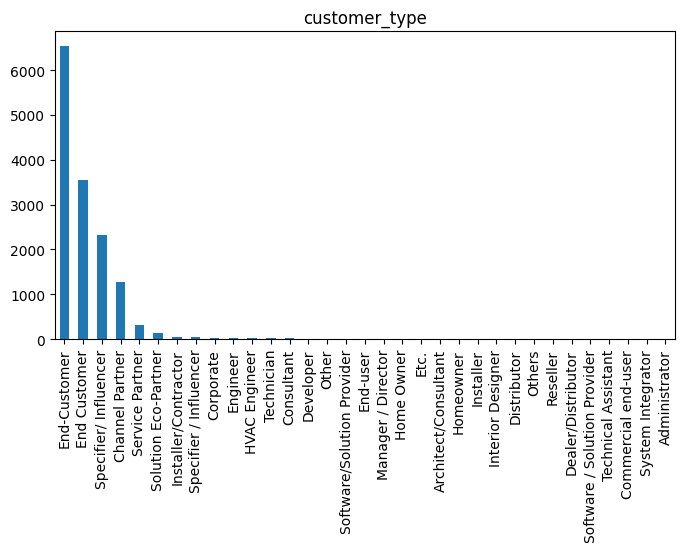

End Customer             2453
Specifier/ Influencer     788
Channel Partner           327
Solution Eco-Partner      146
Service Partner            98
Developer                   1
End-Customer                1
Name: customer_type, dtype: int64


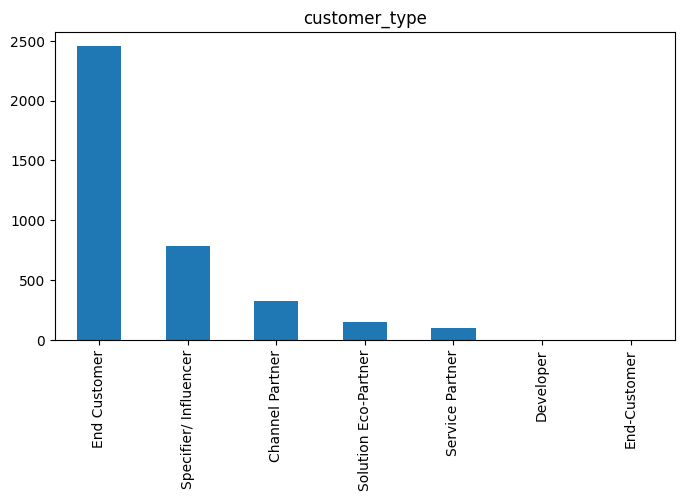

End Customer            10091
Specifier/Influencer     2365
Partner                  1725
Installer                  42
Engineer                   33
Consultant/Designer        25
Developer                  22
Others                     20
Home Owner                 11
Distributor                10
Manager                    10
Name: customer_type, dtype: int64


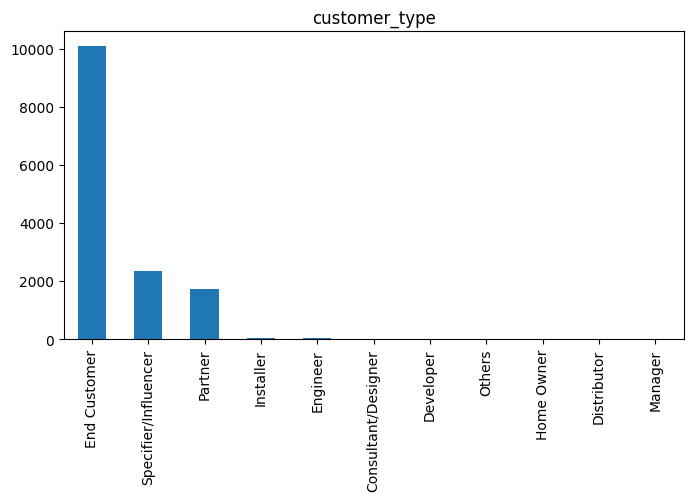

End Customer            2454
Specifier/Influencer     788
Partner                  571
Developer                  1
Name: customer_type, dtype: int64


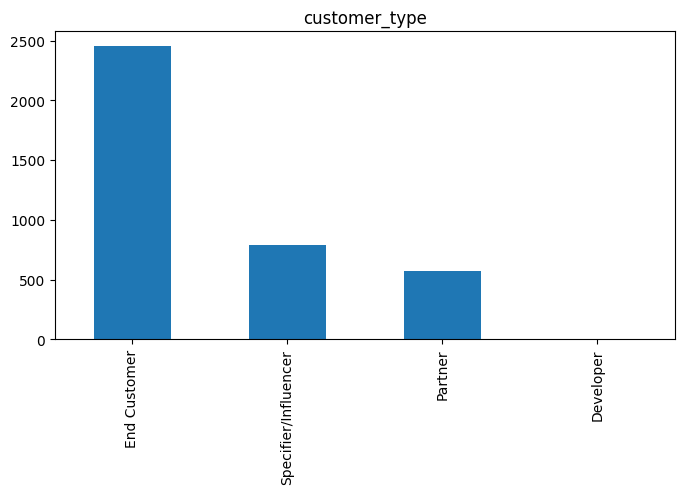

In [ ]:
col = 'customer_type'
customer_type_dict = {
    'End Customer': 'End Customer', 'End-Customer': 'End Customer',  'End-user': 'End Customer',  'Commercial end-user': 'End Customer',
    'Specifier / Influencer': 'Specifier/Influencer', 'Specifier/ Influencer': 'Specifier/Influencer', 'Specifier/Influencer': 'Specifier/Influencer',
    'Homeowner': 'Home Owner','Home Owner': 'Home Owner',

    'Others':'Others', 'Other': 'Others','Etc.': 'Others',
    'Distributor': 'Distributor', 'Dealer/Distributor': 'Distributor',  'Reseller': 'Distributor',
    'Developer': 'Developer', 'Software / Solution Provider': 'Developer', 'Software/Solution Provider': 'Developer',
    'Installer/Contractor': 'Installer',
    'HVAC Engineer': 'Engineer',
    'Technician': 'Engineer',
    'Partner':'Partner', 'Channel Partner': 'Partner', 'Service Partner': 'Partner', 'Solution Eco-Partner': 'Partner',
    'Architect/Consultant': 'Consultant/Designer',
    'Consultant': 'Consultant/Designer',
    'Interior Designer': 'Consultant/Designer',
    'Manager / Director': 'Manager',
    'System Integrator': 'Manager',
    'Technical Assistant': 'Manager',
    'Administrator': 'Manager'
}


plot_value_counts(df_train,df_test, col)
df_train[col] = df_train[col].map(customer_type_dict)
df_test[col] = df_test[col].map(customer_type_dict)
plot_value_counts(df_train,df_test, col)

In [ ]:
col = "product_category"

def product_category_dict(row):
    ess =  ['control', 'vantiliation', 'vrf', 'multi split','multi-split', 'single split','single-split', 'chiller', 'heating','ess', 'energy storage system']
    display = ['monitor', 'labtop', 'projector', 'cloud device', 'medical display',  'monior/monitor tv', 'tv']
    integrated_solution =  ['monitor signage', 'commercial tv',  'monior/monitor tv', 'pc', 'robot',
                            'ess','energy storage system','hvac/ess','hvac'
                            'system ac','sac','system air conditioner' 'ems', 'rac', 'chiller', 'tv', 'refrigerator', 'washing machine', 'aircare','air care', 'vacuum cleaner', 'styler', 'dryer', 'built-in/cooking', 'home beauty', 'water care', 'solar', 'audio/video', 'audio/video ', 'mobile']

    category = row['product_category']
    subcategory = row['product_subcategory']
    business_area = row['business_area']

    if 'solution' in str(category):
        row['product_category'] = 'integrated solution'

    if (',' in str(category)):
        cat_list = category.split(',')
        if cat_list[0] in integrated_solution:
            if cat_list[1] in integrated_solution:
                row['product_category'] = 'integrated solution'

        if cat_list[0] in ess:
            if cat_list[1] in ess:
                row['product_category'] = 'hvac/ess'

        if cat_list[0] in display:
            if cat_list[1] in display:
                row['product_category'] = 'display'

    if category in ['other', 'others', 'otros',' outros','autre', 'not specified','outros','error','parts', 'lainnya','khác','ฯลฯ','آخر',' אחר']:
        row['product_category'] = 'others'

    if category in ['ess', 'hvac', 'hvac/ess', 'energy storage system']:
        row['product_category'] = 'hvac/ess'

    if category in ['medical display', 'medical displays', 'medical monitors', 'medical- surgical']:
        row['product_category'] = 'medical display'

    if category in ['idb', 'interactive digital board', '55tc3d', '互動式顯示屏']:
        row['product_category'] = 'interactive signage'

    if 'uh' in str(category) and 'f' in str(category):
        row['product_category'] = 'uhd signage'

    if 'multi' in str(category):
        row['product_category'] = 'multi-split'

    if ('high' in str(category) and 'brightness' in str(category)) or (category == '高亮度顯示屏') :
        row['product_category'] = 'high brightness signage'

    if 'ultra' in str(category) and 'stretch' in str(category) or '特別顯示屏' in str(category):
        row['product_category'] = 'special signage'

    if 'ur640' in str(category):
        row['product_category'] = 'standard signage'

    if category in ["laec015-gn.awz", 'laec015']:
        row['product_category'] = 'led signage'
        row['product_subcategory'] = 'lg led all in one smart series'
        row['product_modelname'] = category

    if 'led' in str(category) and 'oled' not in str(category):
        row['product_category'] = 'led signage'

    if '.awz'  in str(category) or '.bwz' in str(category):
        row['product_modelname'] = category
        row['product_category'] = 'tv'

    if ' pol' in str(category):
        row['product_category'] = 'tv'

    if 'digital signage' in str(category):
        row['product_category'] = 'digital signage'

    if 'video' in str(category) and 'wall' in str(category):
        row['product_category'] = 'video wall signage'

    if 'one' in str(category) and 'quick' in str(category):
        row['product_category'] = 'one:quick series'

    if category in ['ac rumah','ar condicionado residencial','rac/cac', 'cac', 'aire acondicionado residencial', 'residential air conditioner','เครื่องปรับอากาศเผื่อที่อยู่อาศัย', 'מזגנים למקום מגורים']:
        row['product_category'] = 'rac' # Room air conditioner

    if category in ['sac', 'system ac', 'system air conditioner', 'systèmes de débit à réfrigérant variable (drv)']:
        row['product_category'] = 'sac'

    if 'pro' in str(category) and 'centric' in str(category):
        row['product_category'] = 'pro:centric'

    if category in ["gscd046", "gsca046"]:
        row['product_category'] = 'led signage'
        row['product_subcategory'] = 'ultra light series'
        row['product_modelname'] = 'gsca046'

    if ('tv' in str(category)) and ("hotel" in str(business_area)):
        row['product_category']= 'hotel tv'

    if '酒店電視' in str(category) or '43us660h (na)' in str(category):
        row['product_category'] = 'hotel tv'

    if '特別' in str(category):
        category  = category.replace('特別', 'special ')
        row['product_category'] = category

    if '標準' in str(category):
        category = category.replace('標準', 'standard ')
        row['product_category'] = category

    if '顯示屏' in str(category):
        category = category.replace('顯示屏', 'signage')
        row['product_category'] = category

    if '互動式' in str(category):
        category = category.replace('互動式', 'interactive ')
        row['product_category'] = category

    if '高亮度' in str(category):
        category = category.replace('高亮度', 'high brightness ')
        row['product_category'] = category

    if category in ['ogrzewanie (pompy ciepła)', 'calefacción']:
        row['product_category'] = 'heating'

    if category == 'soğutucu':
        row['product_category'] = 'chiller'
    return row

# apply 함수를 사용하여 각 행에 대해 correct_product_info 함수 적용
df_train = df_train.apply(product_category_dict, axis=1)
value_counts = df_train[col].value_counts()
except_value = value_counts[value_counts == 1].index.tolist()
df_train = df_train[~df_train[col].isin(except_value)]
df_test = df_test.apply(product_category_dict, axis=1)


print(df_train['product_category'][df_train['is_converted']==True].value_counts())
print(df_test['product_category'].value_counts())

interactive signage         579
vrf                         519
video wall signage          377
multi-split                 340
led signage                 321
hotel tv                    271
standard signage            157
oled signage                155
chiller                     147
one:quick series            128
etc.                         91
rac                          90
single-split                 86
high brightness signage      63
monitor                      44
integrated solution          31
special signage              28
tv                           27
medical display              18
heating                      18
hospital tv                  17
webos                        17
commercial tv                11
pro:centric                  10
commercial display           10
smart tv signage              9
digital signage               9
others                        9
uhd signage                   8
accessories                   6
cloud device                  5
hvac/ess

In [ ]:
df_train['product_category'] = df_train['product_category'].str.lower()
df_test['product_category']= df_test['product_category'].str.lower()
df_train['category'] = df_train['product_category'].copy().values
df_test['category'] = df_test['product_category'].copy().values

col = 'category'
# 그룹 이름을 영어로 바꾸기
groups = {
    'COMMERCIAL DISPLAY':['id','idb','互動式顯示屏'],
    'IT PRODUCTS':['uh'],
    'HVAC/ESS':[],
    'COMMERCIAL LAUNDRY':[],
    'COMPRESSOR & MOTOR':[],
    'ROBOT':[],
    'SOLAR':[],
    'SOFTWARE / SERVICE':[],
    'Others': ['etc.', 'others', 'other']
}

# 각 항목을 그룹 이름으로 매핑하는 딕셔너리 생성
item_to_group = {item: group_name for group_name, items in groups.items() for item in items}

# 매핑된 값 적용
for index, row in df_train.iterrows():
    if row[col] in item_to_group:
        df_train.at[index, col] = item_to_group[row[col]]

for index, row in df_test.iterrows():
    if row[col] in item_to_group:
        df_train.at[index, col] = item_to_group[row[col]]
        df_test.at[index, col] = item_to_group[row[col]]


def update_remaining_data(df):
    for index, item in df.iterrows():
        category = str(item['category'])  # 값이 숫자인 경우 문자열로 변환

        if any(keyword in category for keyword in ['it','monitor','pc', 'ultra','uhd','fhd', '4k','ips','laptop','notebook','gram', 'projector', 'probeam', 'cinebeam','projection', 'calculator', 'cloud', 'devices', 'client', 'clinical','medical','diagnostic','surgical', 'x-ray', 'detector','32','34','28','27']):
            df.at[index, 'category'] = 'IT PRODUCTS'

        elif any(keyword in category for keyword in ['vrf', 'ventilation', 'water', 'storage', 'multi', 'inverter', 'chiller', 'pump', 'energy', 'single', 'control', 'split', 'heat', 'air', 'مبرد (تشيلر)','aquecimento','refrigerator', 'pendingin'
                                                     'erv','drv','ogrzewanie','isıtma','soğutucu','hvac','ess']):
            df.at[index, 'category'] = 'HVAC/ESS'

        elif any(keyword in category for keyword in ['washer', 'dryer', 'laundromat', 'housing', 'premise', 'laundry']):
            df.at[index, 'category'] = 'COMMERCIAL LAUNDRY'

        elif any(keyword in category for keyword in ['compressor','rac','sac','cac',' frige','condi',
                                                     'تكييف وتبريد',#에어컨 및 냉각
                                                     'điều hòa gia dụng',#rac
                                                     'تكييفات',#에어컨
                                                     'เครื่องปรับอากาศเผื่อที่อยู่อาศัย',#rac
                                                     ]):
            df.at[index, 'category'] = 'COMPRESSOR & MOTOR'

        elif any(keyword in category for keyword in ['robot']):
            df.at[index, 'category'] = 'ROBOT'

        elif any(keyword in category for keyword in ['solar']):
            df.at[index, 'category'] = 'SOLAR'

        elif any(keyword in category for keyword in ['software','support','centric','webos','軟體']):
            df.at[index, 'category'] = 'SOFTWARE / SERVICE'

        elif any(keyword in category for keyword in ['display','led','lead','signage','magnit','miraclass','transparent','film','wall','board','brightness','interactive',
                                                'one','quick','oled','curvable','flat','monitor','tv','hotel tv','hospitality','special','standard','laec','virtual','vl','vm','ur','uh','us','uq','tc','gscd','svh',
                                                'lsca','86','98','110','顯示屏','retail','電視']):
            df.at[index, 'category'] = 'COMMERCIAL DISPLAY'

    return df

# 데이터프레임 업데이트

df_train = update_remaining_data(df_train)
df_test = update_remaining_data(df_test)

excluded_categories = [
    'COMMERCIAL DISPLAY', 'IT PRODUCTS', 'HVAC/ESS', 'COMMERCIAL LAUNDRY',
    'COMPRESSOR & MOTOR', 'ROBOT', 'SOLAR', 'SOFTWARE / SERVICE', 'Others', np.nan
]

df_train = df_train[df_train['category'].isin(excluded_categories)]
print(df_train[col].value_counts(), sum(df_train[col].value_counts()))
print(df_train[col][df_train['is_converted']==True].value_counts())
print(df_test[col].value_counts(), sum(df_test[col].value_counts()))

COMPRESSOR & MOTOR    9676
COMMERCIAL DISPLAY    9387
HVAC/ESS              8796
IT PRODUCTS           7680
Others                2274
SOFTWARE / SERVICE     302
SOLAR                   13
ROBOT                    6
Name: category, dtype: int64 38134
COMMERCIAL DISPLAY    1473
HVAC/ESS               758
COMPRESSOR & MOTOR     663
IT PRODUCTS            533
Others                 146
SOFTWARE / SERVICE      25
Name: category, dtype: int64
HVAC/ESS               986
IT PRODUCTS            867
COMMERCIAL DISPLAY     843
COMPRESSOR & MOTOR     474
Others                 207
SOFTWARE / SERVICE      24
integrated solution     12
Name: category, dtype: int64 3413


In [ ]:
from sklearn.preprocessing import PowerTransformer
for col in ['historical_existing_cnt','lead_desc_length']:
    if df_train[col].max() > 10:
        df_train[col] = df_train[col].fillna(0)
        df_test[col] = df_test[col].fillna(0)
        scaler = PowerTransformer()
        #df_train[col] = scaler.fit_transform(df_train[[col]])
        #df_test[col] = scaler.transform(df_test[[col]])

In [ ]:
def feature_engineering_to_df(df):
    df = df.applymap(lambda x: x.lower() if type(x) == str else x) # 문자열을 소문자로 변환. #applymap->apply 변경필요
    df = df.applymap(lambda x: 'other' if '?' in str(x) else x) # "?"를 포함하는 셀을 "other"로 대체.
    df = df.applymap(lambda x: 'other' if 'other' in str(x) or 'others' in str(x) or 'etc.' in str(x) else x) # "other"로 대체.

    df = df.replace(to_replace=r'\band \b', value='', regex=True)
    df = df.replace(to_replace=r'\bor \b', value='', regex=True)
    df = df.replace(to_replace=r'\b-\b', value=' ', regex=True)
    df = df.replace(to_replace=r'\b_\b', value=' ', regex=True)
    return df

def feature_engineering_to_col(df, col):
    if col == "enterprise":
        df[col] = df[col].apply(lambda x: 1 if x == 'enterprise' else 0)

    if col in ["id_strategic_ver","it_strategic_ver", "idit_strategic_ver", "ver_win_rate_x", "ver_win_ratio_per_bu", "com_reg_ver_win_rate"]:
        df[col] = df[col].apply(lambda x: x if x > 0 else 0)
        df[col] = df[col].fillna(0)

    if col == 'inquiry_type':
        df[col] = df[col].apply(lambda x: 'quotation purchase consultation' if 'quo' in str(x) or 'purchase' in str(x) else x)
        df[col] = df[col].apply(lambda x: 'product information' if 'product' in str(x) or 'info' in str(x) or 'details' in str(x) else x)   #물음 타입에 제품정보가 들어가면 제품정보로 통일

        #제품 카테고리명이 들어가는 경우에도 제품 정보로 통일
        product_category = df['product_category'].unique().tolist()
        for product in product_category:
            df[col] = df[col].apply(lambda x: 'product information' if str(product) in str(x) else x)

        product_subcategory = df['product_subcategory'].unique().tolist()
        for product in product_subcategory:
            df[col] = df[col].apply(lambda x: 'product information' if str(product) in str(x) else x)
        df[col] = df[col].apply(lambda x: 'customer suggestions' if 'suggestions' in str(x) else x)
        df[col] = df[col].apply(lambda x: 'technical consultation' if 'technical' in str(x) else x)
        df[col] = df[col].apply(lambda x: 'partnership or distributorship' if 'partnership' in str(x) or 'distributorship' in str(x) else x)

        df[col] = df[col].apply(lambda x: 'sales' if 'sales' in str(x) else x)
        df[col] = df[col].apply(lambda x: 'no inquiry' if x == np.nan else x)
        df[col] = df[col].apply(lambda x: 'other' if x not in ['quotarion purchase consultation', 'product information', 'technical consultation','trainings','sales', 'partnership or distributorship', 'no inquiry'] else x)

    if col == 'product_modelname':
        #앞에서 6자리만 남기고 나머지는 삭제
        df[col] = df[col].apply(lambda x: x[:6] if len(str(x)) > 6 else x)

    if col == 'customer_position':
        df[col] = df[col].apply(lambda x: 'other' if 'no ' in str(x) or 'not ' in str(x) else x)#0.2
        df[col] = df[col].apply(lambda x: 'faculty' if 'pgt' in str(x) or 'professor' in str(x) or 'faculty' in str(x) else x) #0.8
        df[col] = df[col].apply(lambda x: 'educator' if 'teach' in str(x) or 'educat' in str(x) or 'academic' in str(x) or 'lecture' in str(x) or 'college' in str(x) else x) #0.4

        df[col] = df[col].apply(lambda x: 'engineer' if 'engineer' in str(x) or 'manufact' in str(x) else x) #0.4
        df[col] = df[col].apply(lambda x: 'consultant' if 'consult' in str(x) or 'coach' in str(x) or 'solution' in str(x) else x) #0.5
        df[col] = df[col].apply(lambda x: 'medical' if 'hospital' in str(x) or 'medical' in str(x) else x) #0.5
        df[col] = df[col].apply(lambda x: 'end user' if 'end user' in str(x) or 'customer' in str(x) else x) #0.5

        df[col] = df[col].apply(lambda x: 'chief level' if 'ceo' in str(x) or 'c level' in str(x) or 'executive' in str(x) or 'owner' in str(x) or 'decision maker' in str(x) or 'founder' in str(x) or 'boss' in str(x) or x in ['president'] else x) #1
        df[col] = df[col].apply(lambda x: 'vice president' if 'vp' in str(x) or 'vice' in str(x) else x) #0.8
        df[col] = df[col].apply(lambda x: 'partner' if 'partner' in str(x) else x) #0.6
        df[col] = df[col].apply(lambda x: 'director' if 'director' in str(x) or x in ['chairman'] else x) #0.8
        df[col] = df[col].apply(lambda x: 'manager' if 'manage' in str(x) or 'administrative' in str(x) else x) #0.6
        df[col] = df[col].apply(lambda x: 'associate/analyst' if 'employee' in str(x) or 'prof' in str(x) else x) #0.4
        df[col] = df[col].apply(lambda x: 'intern' if 'trainee' in str(x) in str(x) or 'entry' in str(x) or x in ['unpaid'] else x) #0.2

        df[col] = df[col].apply(lambda x: 'other' if x not in ['consultant', 'educator','faculty', 'engineer', 'end user', 'medical', 'associate/analyst', 'intern', 'chief level', 'vice president', 'partner', 'director', 'manager', 'none'] else x)#0.2

        def assign_position_weight(position):
            weights = {
                'chief level': 1.0,
                'vice president': 0.8,
                'director': 0.8,
                'partner': 0.6,
                'manager': 0.6,
                'associate/analyst': 0.4,
                'intern': 0.2,

                'faculty':0.8,
                'educator': 0.4,
                'engineer': 0.4,

                'consultant': 0.5,
                'end user': 0.5,
                'medical': 0.5,
                'other': 0.5,  # 가정: 'other' 범주에 대한 가중치는 0.2로 설정
                'none' : 0.5
            }
            # 'position' 값에 해당하는 가중치 반환, 없는 경우 'other'의 가중치 반환
            return weights.get(position, 0.5)

        df['ver_position'] = df[col].apply(assign_position_weight)

    if col == 'expected_timeline':
        def preprocess_timeline(x):
            x = str(x)
            if 'less than 3 months' in x:
                return '0~3'
            elif ('3 months' in x and '6 months' in x) :
                return '3~6'
            elif ('6 months' in x and '9 months' in x) :
                return '6~9'
            elif ('9 months' in x or 'year' in x):
                return '9~12'
            elif 'more than 1 year' in x or 'more than a year' in x:
                return '12~'
            elif '2 months'  in x or '1 month' in x or 'december' in x or 'nomemver' in x or 'october' in x or '5 months' in x or '4 months' in x or '45 day' in x or '8 months' in x or '7 months' in x:
                return 'specified'
            elif any(keyword in x for keyword in ['already']):
                return 'already'
            elif any(keyword in x for keyword in ['quot', 'customer', 'update', 'share', 'client', 'details']):
                return 'related with customer'
            elif any(keyword in x for keyword in ['not require', 'no require', 'no', 'not ', 'issue', 'problem']):
                return 'no requirement'
            else:
                return 'other'  # 조건에 맞지 않는 경우 'unknown' 카테고리 할당

        # 'expected_timeline' 컬럼에 preprocess_timeline 함수 적용
        df[col] = df[col].apply(preprocess_timeline)

    return df

df_train = feature_engineering_to_df(df_train)
df_test = feature_engineering_to_df(df_test)

for col in df_train.columns:
    df_train = feature_engineering_to_col(df_train, col)
    df_test = feature_engineering_to_col(df_test, col)

#df_train.to_excel("train_preprocessed.xlsx", index=False) # 전처리한 데이터 저장


# ***가중치에 따른 T/F분포 코드***

* 수정 필요 부분 ctrl+F 로 체크 (google colab tool을 써서 조금 다른 부분들)

-> 생각보다 분포에 특징을 보이지 않는 듯 함. 가중치 아이디어 수정 필요

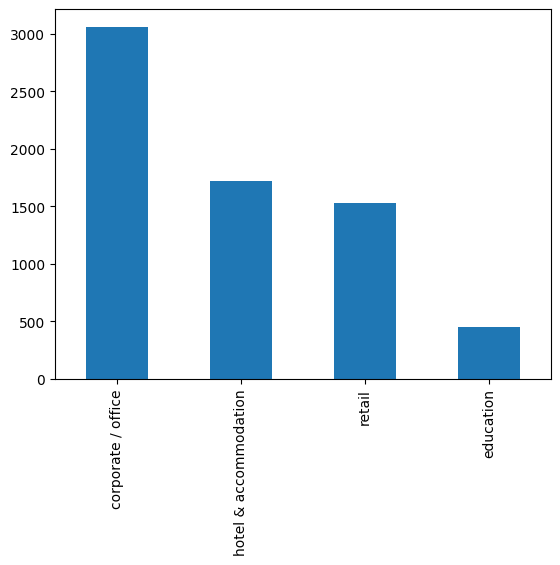

29536    3.001
30055    3.001
30042    3.001
30043    3.001
30044    3.001
         ...  
18317    0.001
18318    0.001
18319    0.001
18320    0.001
55760    0.001
Name: weight, Length: 55233, dtype: float64


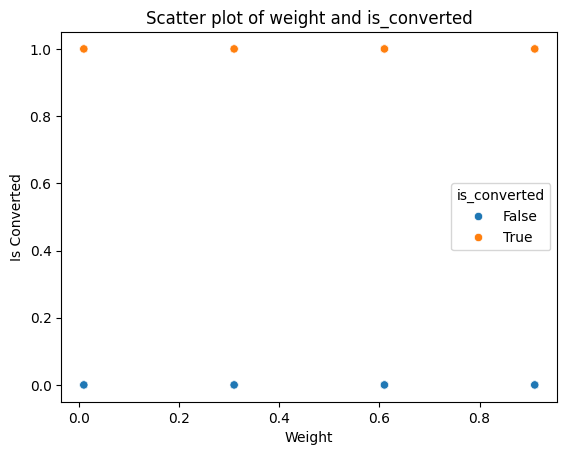

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

# 가중치 = 가중치 변수들이 1이 된 수(높을수록 제품 구매할 사람) * vertical level1에서 차지하는 비율 * 영업전환된 퍼센트(historical_existing_cnt)
# 가중치에 따른 T/F 찍어보기
# 'weight' 컬럼 추가 (임시변수)
conditions = [
    (df_train['idit_strategic_ver'].isna() & df_train['ver_cus'].isna() & df_train['ver_pro'].isna()),
    (df_train[['idit_strategic_ver', 'ver_cus', 'ver_pro']].sum(axis=1) == 0),
    (df_train[['idit_strategic_ver', 'ver_cus', 'ver_pro']].sum(axis=1) >= 1)
]
choices = [-1, 0, 1]
df_train['weight'] = np.select(conditions, choices)

# 사업영역 빈도 막대그래프 생성 및 출력 -> vertical level1알아보기
df_train.loc[df_train['weight'] == 1, 'business_area'].value_counts().sort_values(ascending=False).plot(kind='bar')
plt.show()

# 각 가중치 컬럼들이 1일 때의 개수
df_train['weight_count'] = df_train[['it_strategic_ver', 'id_strategic_ver', 'ver_cus', 'ver_cus']].sum(axis=1)
# NaN일 때의 개수
df_train['nan_count'] = df_train[['it_strategic_ver', 'id_strategic_ver', 'ver_cus', 'ver_cus']].isnull().sum(axis=1)

# 'historical_existing_cnt'에서 차지하는 비율
total_historical_existing_cnt = df_train['historical_existing_cnt'].sum()
df_train['historical_existing_ratio'] = df_train['historical_existing_cnt'] / total_historical_existing_cnt

# 'business_area'의 값이 vertical_level1에서 차지하는 비율
vertical_level1 = ['corporate / office', 'hotel & accommodation', 'retail', 'education']
df_vertical = df_train[df_train['business_area'].isin(vertical_level1)] # 'business_area' 값이 vertical_level1에 속하는 행만 선택
business_area_counts = df_vertical['business_area'].value_counts() # vertical_level1에서 각 'business_area' 값의 빈도 계산
business_area_ratio = business_area_counts / len(df_vertical) # 각 'business_area' 값의 빈도를 vertical_level1의 전체 개수로 나눠 비율 계산
business_area_ratio = business_area_ratio.to_dict() # 'business_area_ratio' 딕셔너리 생성: {business_area: ratio}
df_train['business_area_ratio'] = df_train['business_area'].map(business_area_ratio) # 0.377898~0.159583
df_train['business_area_ratio'].fillna(0.001, inplace=True) # vertical_level1에 속하지 않는 값들은 0.001
#print(df_train[df_train['business_area_ratio'] > 0]['business_area_ratio'].sort_values(ascending=False))

# 가중치 컬럼 수정. 0이 되지 않도록 bias 더함
df_train['weight'] = (df_train['weight_count'] + df_train['nan_count'] * 0.5 + 0.001) * (df_train['historical_existing_ratio'] + 0.001) * df_train['business_area_ratio']
#print(df_train['weight'].sort_values(ascending=False))

# 'weight'컬럼 정규화
scaler = MinMaxScaler()
df_train['weight'] = scaler.fit_transform(df_train['weight'].values.reshape(-1,1)) * 0.9 + 0.01 # 0.01~1로 정규화
#print(df_train['weight'].sort_values(ascending=False))

# 'weight'컬럼 값에 따른 T/F분포
sns.scatterplot(x='weight', y='is_converted', hue='is_converted', data=df_train) # 'is_converted' 컬럼이 True/False에 따라 다른 색으로 점 찍기

plt.title('Scatter plot of weight and is_converted')
plt.xlabel('Weight')
plt.ylabel('Is Converted')

plt.show()


In [ ]:
# 레이블 인코딩할 칼럼들
label_columns = [
    "customer_country",
    "business_subarea",
    "business_area",
    "business_unit",
    "customer_type",
    "customer_job",
    "inquiry_type", #one-hot encoding
    "product_category",
    "product_subcategory",
    "product_modelname",
    "customer_position",#one-hot encoding
    "response_corporate",
    "expected_timeline",
    "lead_owner", #category로 추가해야함! -> cat 성능 증가
    "category",
    "response_corporate_contry",
    ]

df_all = pd.concat([df_train[label_columns], df_test[label_columns]])

for col in label_columns:
    df_all[col] = label_encoding(df_all[col])

for col in label_columns:
    df_train[col] = df_all.iloc[:len(df_train)][col]
    df_test[col] = df_all.iloc[len(df_train):][col]

one_hot_columns = [
                #'inquiry_type',
                ]

for col in one_hot_columns:
    OHE = OneHotEncoder(sparse_output = False)
    ohe_train = OHE.fit_transform(df_train[[col]])
    ohe_train_df = pd.DataFrame(ohe_train, columns= [col +'_'+ str(i) for i in OHE.categories_[0]])
    df_train = pd.concat([df_train, ohe_train_df], axis=1)

    ohe_test = OHE.transform(df_test[[col]])
    ohe_test_df = pd.DataFrame(ohe_test, columns=[col +'_'+ str(i) for i in OHE.categories_[0]])
    df_test = pd.concat([df_test, ohe_test_df], axis=1)

df_train.fillna(9999, inplace=True)
df_test.fillna(9999, inplace=True)
df_train[label_columns] = df_train[label_columns].astype('category')
df_test[label_columns] = df_test[label_columns].astype('category')

In [ ]:
#df_train_clean = df_train.drop_duplicates().reset_index(drop=True)
#df_train = df_train.drop_duplicates().reset_index(drop=True)

drop_columns=[
            "business_unit",
            "customer_idx",
            "customer_job",
            "enterprise",
            #"product_subcategory",
            #"product_modelname", # 많은 카테고리 # 가중치로 변환
            "customer_country.1",
            "customer_country",
            "business_area",
            #"business_subarea",
            "id_strategic_ver",
            "it_strategic_ver",
            "idit_strategic_ver",
            #"ver_pro",
            #"ver_cus",
            #"ver_win_rate_x",
            #"ver_win_ratio_per_bu",
            #"response_corporate",
            #"customer_position"

            #Feature Engineering
            #"response_corporate_contry",
            #"ver_position",
            #"contry_to_response_corporate",
            "category",
            #"lead_owner",
            #"lead_desc_length",
            ]

cat_features = [col for col in df_train.columns if df_train[col].dtype.name == "category" and col not in drop_columns]

X_train, X_val, y_train, y_val = train_test_split(
    df_train.drop(["is_converted"]+drop_columns, axis=1),
    df_train["is_converted"],
    test_size=0.1,
    shuffle=True,
    random_state=300,
    stratify=df_train["is_converted"],
)

print(y_train.value_counts())

is_converted
False    45589
True      4120
Name: count, dtype: int64


In [ ]:
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from lightgbm import LGBMClassifier

from sklearn.model_selection import StratifiedKFold

# 하이퍼파라미터 공간 정의
search_spaces = {
    'n_estimators': Integer(100, 500, prior='uniform'),
    'learning_rate': Real(0.001, 1, prior='log-uniform'),
    'subsample': Real(0.5, 0.8, prior='uniform'),
    'colsample_bytree': Real(0.5, 0.8, prior='uniform'),
    'reg_lambda': Real(1e-9, 10, prior='log-uniform'),
    'reg_alpha': Real(1e-9, 10, prior='log-uniform'),
    'min_child_samples': Integer(2, 20, prior='log-uniform'),
}

# 모델 초기화
model_lgb = LGBMClassifier(objective='binary', verbose=0, class_weight='balanced', random_state= 42)

# 베이지안 최적화 실행을 위한 BayesSearchCV 초기화
opt = BayesSearchCV(
    estimator=model_lgb,
    search_spaces=search_spaces,
    scoring='f1',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_iter=30,
    n_jobs=-1,
    return_train_score=False,
    refit=True,
    random_state=42
)

# 최적화 실행
opt.fit(X_train, y_train)

# 결과 출력
print(f"Best score: {opt.best_score_}\n")
best_params_lgb = opt.best_params_

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
Best score: 0.6920964994113439



In [ ]:
import lightgbm as lgb
model_lgb = LGBMClassifier(objective='binary', verbose =3,
                              class_weight='balanced', random_state=42,
                               **best_params_lgb)
callbacks = [lgb.log_evaluation()]
#model_lgb = lgb.train(train_set = lgb.Dataset(X_train, label=y_train), valid_sets = lgb.Dataset(X_val, label=y_val), params = best_params_lgb, valid_names = 'val', callbacks=callbacks)
model_lgb.fit(X_train, y_train, eval_set = [(X_val, y_val)], eval_metric = 'f1', callbacks=callbacks)
pred = model_lgb.predict(X_val)
#pred = np.where(pred > 0.5, 1, 0)
get_clf_eval(y_val, pred)

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 4120, number of negative: 45589
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.823751
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.488196
[LightGBM] [Debug] init for col-wise cost 0.001027 seconds, init for row-wise cost 0.001595 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001296 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Sparse Multi-Val Bin
[LightGBM] [Info] Total Bins 1889
[LightGBM] [Info] Number of data points in the train set: 49709, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: 

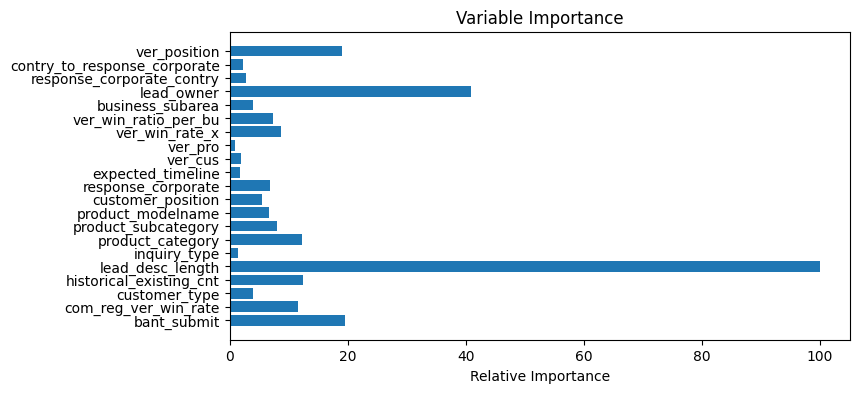

In [ ]:
#feature importance
import matplotlib.pyplot as plt
import seaborn as sns

feature_importance = model_lgb.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(8, 4))
plt.barh(pos, feature_importance)#[sorted_idx])
plt.yticks(pos, X_train.columns)#[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [ ]:
# 예측에 필요한 데이터 분리
x_test = df_test.drop(["is_converted", "id"]+drop_columns, axis=1)

In [ ]:
models = [model_lgb,
          ]
preds = []
for model in models:
    #model.fit(df_train.drop(["is_converted"]+drop_columns, axis=1), df_train["is_converted"])
    pred = model.predict(x_test)
    #pred = [True if x == 'True' or x ==True else False for x in pred]
    preds.append(pred)
test_pred = np.floor(np.mean(preds, axis=0) + 0.5).astype(int)

print(sum(test_pred), len(test_pred)) # True로 예측된 개수

667 5271


In [ ]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["is_converted"] = test_pred
df_sub[df_sub['customer_idx']==25096]["is_converted"] = "TRUE"

# 제출 파일 저장
df_sub["is_converted"].apply(lambda x : "TRUE" if x == "true" or x==1 else "FALSE")
df_sub.to_csv("submission.csv", index=False)